#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
import seaborn as sns
import io
import json

In [2]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

#### Loading Dataset

In [3]:
data = pd.read_csv("Datasets\\a1_IMDB_Dataset.csv")

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.shape

(50000, 2)

In [12]:
data.isnull().values.sum()

0

<AxesSubplot: xlabel='sentiment', ylabel='count'>

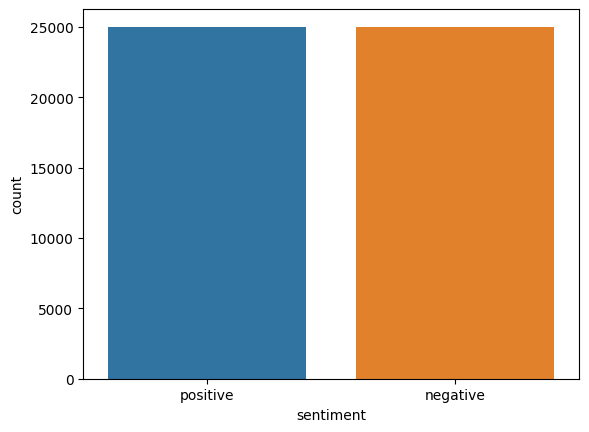

In [14]:
sns.countplot(x='sentiment', data = data)

#### Data Preprocessing

In [15]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [16]:
data['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [4]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Md Mubeen Ali
[nltk_data]     Zaki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [7]:
X = []
sentences = list(data['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [21]:
X[1]

'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done '

In [8]:
y = data['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Embedding Layer

In [10]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

In [11]:
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [12]:
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [13]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [14]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
embeddings_dictionary = dict()

#Download link: https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [16]:
embedding_matrix = np.zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
embedding_matrix.shape

(92394, 100)

#### Model Training

#### Simple Neural Network

In [18]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [19]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,249,401
Trainable params: 10,001
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [20]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 4s 8ms/step - loss: 0.5601 - acc: 0.7121 - val_loss: 0.5050 - val_acc: 0.7606
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4509 - acc: 0.7937 - val_loss: 0.5125 - val_acc: 0.7546
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4126 - acc: 0.8171 - val_loss: 0.5005 - val_acc: 0.7607
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3912 - acc: 0.8278 - val_loss: 0.5266 - val_acc: 0.7549
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3763 - acc: 0.8347 - val_loss: 0.5241 - val_acc: 0.7573
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3633 - acc: 0.8430 - val_loss: 0.5431 - val_acc: 0.7545


In [21]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5670 - acc: 0.7446


In [22]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5669899582862854
Test Accuracy: 0.7445999979972839


313/313 [==============================] - 1s 2ms/step


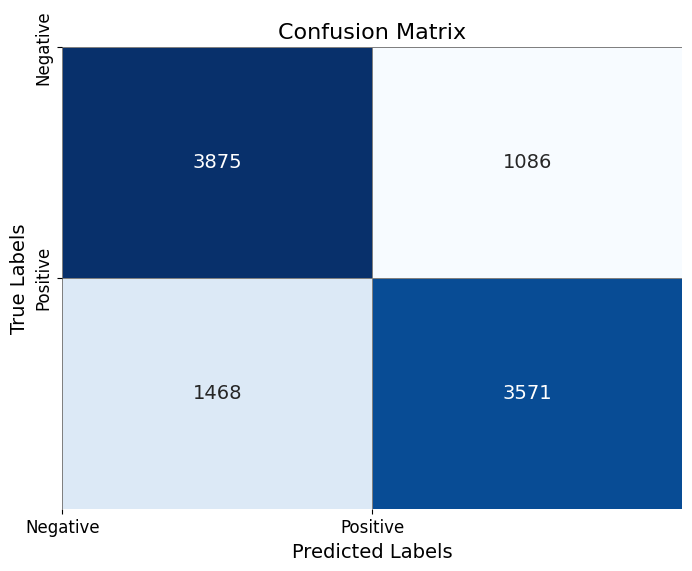

              precision    recall  f1-score   support

    Negative       0.73      0.78      0.75      4961
    Positive       0.77      0.71      0.74      5039

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming snn_model is your trained Simple Neural Network model

# Predict probabilities for classes on test data
y_pred_probs = snn_model.predict(X_test)
y_pred = np.round(y_pred_probs).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], fontsize=12)
plt.yticks(ticks=[0, 1], labels=['Negative', 'Positive'], fontsize=12)
plt.show()

# Optionally, print classification report for detailed metrics
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.75
Recall: 0.74
F1 Score: 0.74


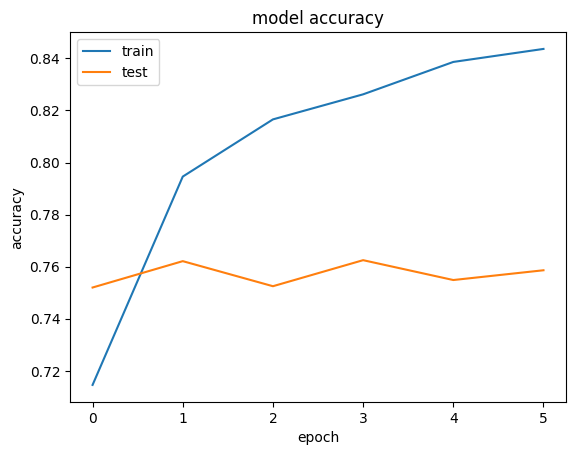

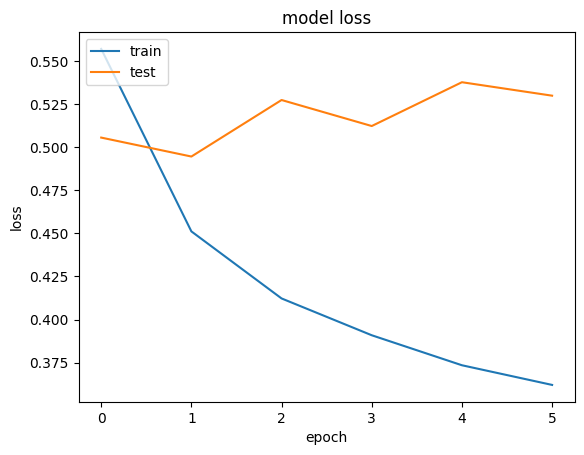

In [41]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### CNN

In [35]:
from keras.layers import Conv1D

In [36]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [37]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 


 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [38]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 13s 45ms/step - loss: 0.4643 - acc: 0.7792 - val_loss: 0.3789 - val_acc: 0.8328
Epoch 2/6
250/250 [==============================] - 11s 43ms/step - loss: 0.3372 - acc: 0.8565 - val_loss: 0.3465 - val_acc: 0.8475
Epoch 3/6
250/250 [==============================] - 11s 46ms/step - loss: 0.2834 - acc: 0.8864 - val_loss: 0.3345 - val_acc: 0.8518
Epoch 4/6
250/250 [==============================] - 13s 51ms/step - loss: 0.2408 - acc: 0.9111 - val_loss: 0.3330 - val_acc: 0.8528
Epoch 5/6
250/250 [==============================] - 12s 49ms/step - loss: 0.1974 - acc: 0.9347 - val_loss: 0.3314 - val_acc: 0.8544
Epoch 6/6
250/250 [==============================] - 12s 49ms/step - loss: 0.1639 - acc: 0.9508 - val_loss: 0.3350 - val_acc: 0.8540


In [39]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 7ms/step - loss: 0.3344 - acc: 0.8554


In [40]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33437883853912354
Test Accuracy: 0.855400025844574


313/313 [==============================] - 2s 5ms/step


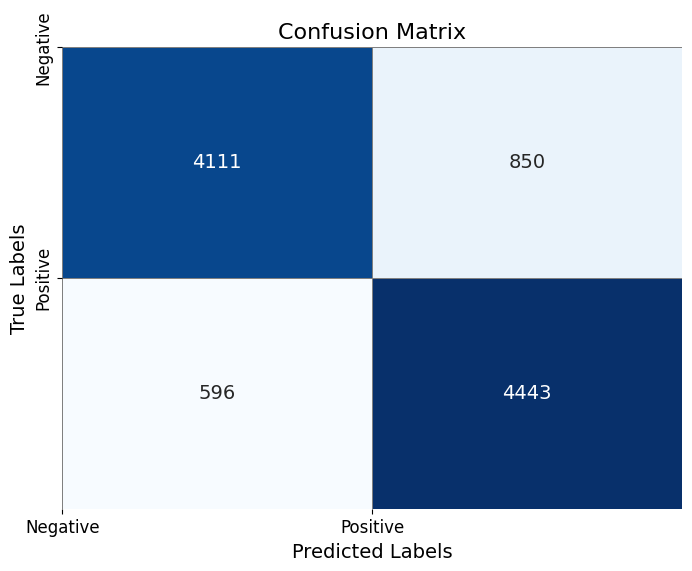

              precision    recall  f1-score   support

    Negative       0.87      0.83      0.85      4961
    Positive       0.84      0.88      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [42]:
y_pred_probs1 = cnn_model.predict(X_test)
y_pred1 = np.round(y_pred_probs1).astype(int)

# Calculate confusion matrix
conf_matrix1 = confusion_matrix(y_test, y_pred1)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], fontsize=12)
plt.yticks(ticks=[0, 1], labels=['Negative', 'Positive'], fontsize=12)
plt.show()

# Optionally, print classification report for detailed metrics
print(classification_report(y_test, y_pred1, target_names=['Negative', 'Positive']))

In [59]:
precision1 = precision_score(y_test, y_pred1, average='weighted')
recall1 = recall_score(y_test, y_pred1, average='weighted')
f11 = f1_score(y_test, y_pred1, average='weighted')

# Print results
print(f"Precision: {precision1:.2f}")
print(f"Recall: {recall1:.2f}")
print(f"F1 Score: {f11:.2f}")

Precision: 0.86
Recall: 0.86
F1 Score: 0.86


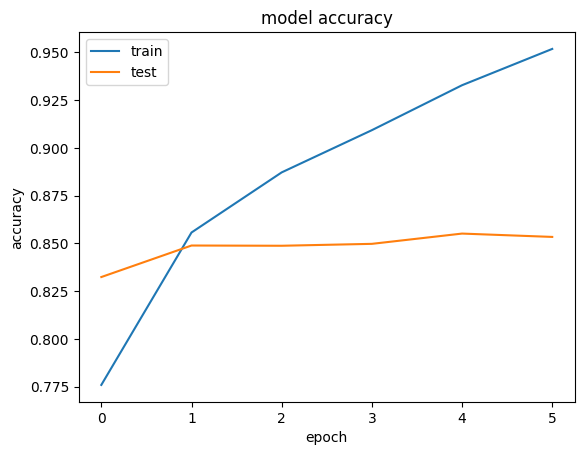

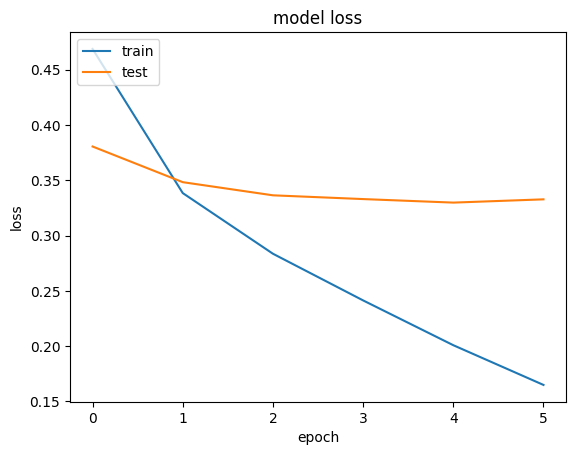

In [48]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#### RNN (LSTM)

In [50]:
from keras.layers import LSTM

In [51]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [52]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    


                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [53]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 49s 186ms/step - loss: 0.5026 - acc: 0.7544 - val_loss: 0.4121 - val_acc: 0.8133
Epoch 2/6
250/250 [==============================] - 76s 303ms/step - loss: 0.4117 - acc: 0.8145 - val_loss: 0.4053 - val_acc: 0.8288
Epoch 3/6
250/250 [==============================] - 69s 275ms/step - loss: 0.3698 - acc: 0.8394 - val_loss: 0.3425 - val_acc: 0.8533
Epoch 4/6
243/250 [============================>.] - ETA: 1s - loss: 0.3324 - acc: 0.8588

KeyboardInterrupt: 

In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 14s 38ms/step - loss: 0.3654 - acc: 0.8379


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3654433786869049
Test Accuracy: 0.8378999829292297


In [56]:
#Loading trained model
from keras.models import Sequential, load_model

model_path ='Models\\lstm_model_acc_0.867.h5'
lstm_model = load_model(model_path)

313/313 [==============================] - 11s 33ms/step


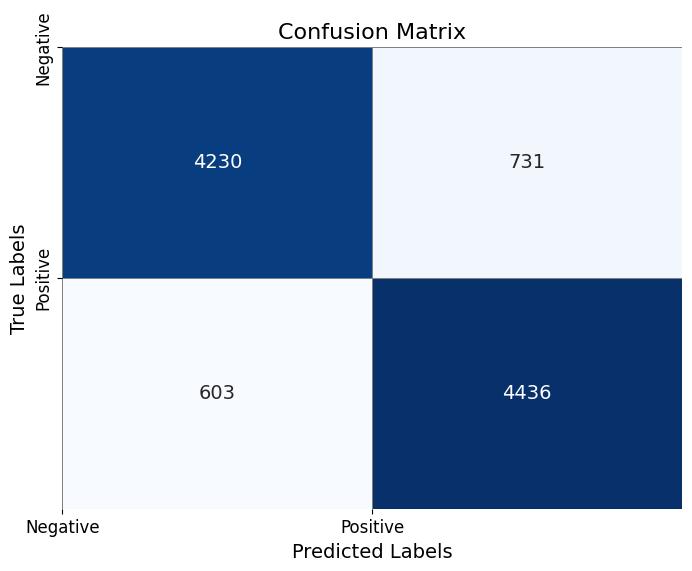

              precision    recall  f1-score   support

    Negative       0.88      0.85      0.86      4961
    Positive       0.86      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [57]:
y_pred_probs2 = lstm_model.predict(X_test)
y_pred2 = np.round(y_pred_probs2).astype(int)

# Calculate confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred2)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], fontsize=12)
plt.yticks(ticks=[0, 1], labels=['Negative', 'Positive'], fontsize=12)
plt.show()

# Optionally, print classification report for detailed metrics
print(classification_report(y_test, y_pred2, target_names=['Negative', 'Positive']))

In [60]:
precision2 = precision_score(y_test, y_pred2, average='weighted')
recall2 = recall_score(y_test, y_pred2, average='weighted')
f12 = f1_score(y_test, y_pred2, average='weighted')

# Print results
print(f"Precision: {precision2:.2f}")
print(f"Recall: {recall2:.2f}")
print(f"F1 Score: {f12:.2f}")

Precision: 0.87
Recall: 0.87
F1 Score: 0.87


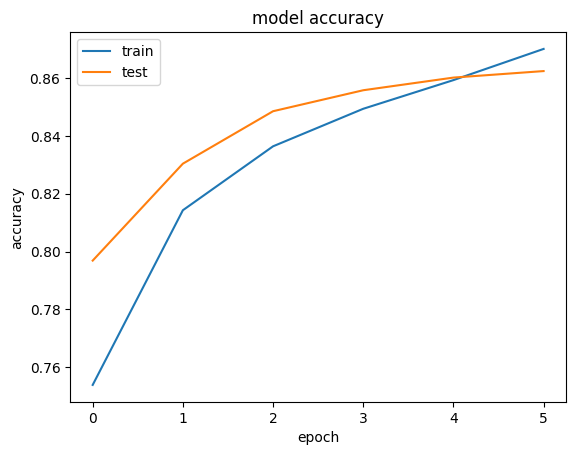

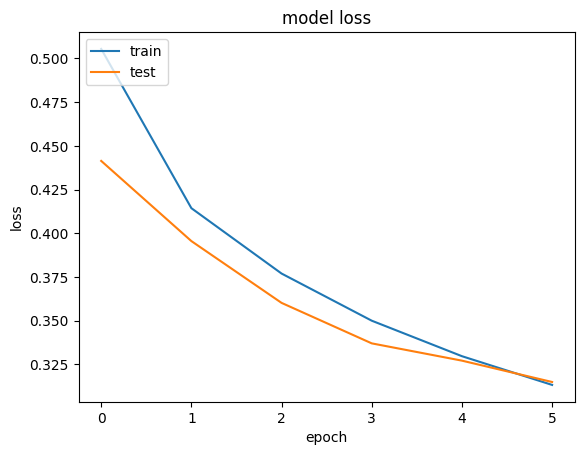

In [55]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### Saving Models

In [56]:
lstm_model.save(f"Models/lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')
cnn_model.save(f"Models/cnn_model_acc_{round(score[1], 3)}.h5", save_format='h5')
snn_model.save(f"Models/snn_model_acc_{round(score[1], 3)}.h5", save_format='h5')

#### Predictions

In [62]:
from keras.models import load_model

model_path ='Models\\lstm_model_acc_0.867.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.
pretrained_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________


In [63]:
sample_reviews = pd.read_csv("Datasets\\a2_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [65]:
unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [66]:
unseen_processed

['intelligent movie movie obviously allegorical fascinating tale ai mainly manipulation power wanting action spectacular cgi movie aimed people like think rather passively wait entertained themes ai also surveillance excellent points data us collected phone companies search engine companies commercial operating systems makers plot seems simple extremely clever protagonist playing games trying stay one step ahead one another movie perfectly consistent internal logic plays perfectly go expecting much however see people satisfied movie sets brilliantly therefore give least recent movies getting movie succeeds another recent movie ai transcendence think called failed interesting failure third movie ai spanish movie called eva also brilliant eva moving movie philosophical movies perfect different ways ai name movie ava seems nod title spanish movie aside nice stars appeared ex machina eva casting great course several aspects movie unrealistic often absurd allegorical movie acceptable movie 

In [67]:
from keras_preprocessing.text import tokenizer_from_json

In [68]:
with open('b3_tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [69]:
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)

In [70]:
unseen_tokenized

[[925,
  1,
  1,
  400,
  14420,
  1289,
  627,
  14035,
  1266,
  7357,
  511,
  1524,
  97,
  1863,
  1370,
  1,
  3416,
  16,
  4,
  25,
  140,
  20211,
  716,
  2161,
  1270,
  14035,
  18,
  12177,
  199,
  659,
  9047,
  76,
  9587,
  1378,
  4780,
  1464,
  6932,
  4780,
  2013,
  7929,
  7741,
  1034,
  33,
  83,
  463,
  435,
  879,
  1740,
  282,
  1469,
  150,
  626,
  3,
  1434,
  1291,
  3,
  62,
  1,
  806,
  4114,
  5415,
  1989,
  191,
  806,
  51,
  854,
  13,
  88,
  11,
  16,
  4012,
  1,
  589,
  1958,
  1398,
  93,
  113,
  1014,
  24,
  270,
  1,
  2759,
  62,
  1014,
  1,
  14035,
  25602,
  25,
  315,
  1064,
  115,
  1852,
  736,
  1,
  14035,
  1776,
  1,
  315,
  3822,
  18,
  383,
  3822,
  569,
  1,
  4051,
  24,
  284,
  164,
  624,
  14035,
  261,
  1,
  12806,
  83,
  5440,
  294,
  1776,
  1,
  1011,
  213,
  278,
  1374,
  1040,
  14943,
  3822,
  897,
  17,
  151,
  312,
  1264,
  1,
  1928,
  285,
  1602,
  14420,
  1,
  3172,
  1,
  122,
  659,
  14

In [71]:
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [72]:
unseen_padded

array([[  879,  1740,   282,  1469,   150,   626,     3,  1434,  1291,
            3,    62,     1,   806,  4114,  5415,  1989,   191,   806,
           51,   854,    13,    88,    11,    16,  4012,     1,   589,
         1958,  1398,    93,   113,  1014,    24,   270,     1,  2759,
           62,  1014,     1, 14035, 25602,    25,   315,  1064,   115,
         1852,   736,     1, 14035,  1776,     1,   315,  3822,    18,
          383,  3822,   569,     1,  4051,    24,   284,   164,   624,
        14035,   261,     1, 12806,    83,  5440,   294,  1776,     1,
         1011,   213,   278,  1374,  1040, 14943,  3822,   897,    17,
          151,   312,  1264,     1,  1928,   285,  1602, 14420,     1,
         3172,     1,   122,   659,   140, 13082,  1645, 10209,  1615,
          937],
       [  121,   234,   352,  8844,  6752,   630,    20,  6507,    72,
         1400,  6730,  2885, 24074, 10547,  3633,  1645,    25, 11701,
         1335, 19425,    26,   281,  1574,  1143,   288, 1370

In [73]:
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 646ms/step


array([[0.9081877 ],
       [0.98810476],
       [0.15965328],
       [0.76896846],
       [0.9540804 ],
       [0.01757479]], dtype=float32)

In [74]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

In [75]:
dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.1
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.6
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,7.7
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.5
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2


In [76]:
unseen_sentiments[0][0]

0.9081877